In [1]:
import sys
sys.path.append("../")
import numpy as np
import matplotlib.pyplot as plt
from GraphDataset import GraphDataset, MultiGraphDataset
from creditlearning import CreditLearner
import matplotlib


matplotlib.font_manager._rebuild()
plt.rcParams.update({'font.size': 22, 'font.family': 'Arial',
                    'mathtext.fontset': 'custom',
                    'mathtext.rm': 'Arial',
                    'mathtext.cal': 'Arial:italic',
                    'mathtext.it': 'Arial:italic',
                    'mathtext.bf': 'Arial:bold'})

### Demonstration of multiple superimposed processes

Each process has 3 event types. The transition matrix is
\begin{matrix} 
0.05 & 0.75 & 0.2\\ 
0.2 & 0.05 & 0.75\\ 
0.75 & 0.2 & 0.05
\end{matrix}

The transition times between events are chosen to be normal with a lower bound cutoff, which here is chosen to be 0.0001. The means and variances for each transition are drawn from uniform distributions. Here the means are drawn from $\text{Unif} \sim [0,10]$ and variances from $\text{Unif} \sim [0,2]$. 

We simulate a maximum of 7 superimposed processes here. 


In [2]:
np.random.seed(50)
dt = 0.01

def dist(x,i):
    if i%3==0:
        #return np.array([0.05,0.75,0.2])
        return np.array([0.,1.,0.])
    elif i%3==1:
        #return np.array([0.2,0.05,0.75])
        return np.array([0.,0.,1.])
    else:
        #return np.array([0.75,0.2,0.05])
        return np.array([1.,0.,0.])

mean_scale = 10
var_scale = 2
min_cutoff = 0.0001

maxNumProcesses = 2
numNodesList = [3 for i in range(maxNumProcesses)]
pList = [1 for i in range(maxNumProcesses)]
scaleList = [(mean_scale,var_scale) for i in range(maxNumProcesses)]
multigraph1 = MultiGraphDataset(numNodesList=numNodesList,
                                pList=pList,
                                scaleList=scaleList,
                                uniformTime=0,
                                dist=dist,
                                uniformTransitions=False,
                                dt=dt,
                                labelList=None
                               )


Graph showing the connections between events, with edge weights representing mean transition times. 

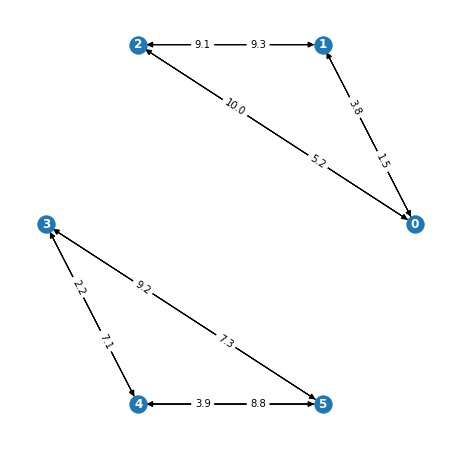

Transition probs and times for first process


{0: {0: {'weight': 3.963299097227769, 'var': 0.8163944006663941, 'prob': 0.0},
  1: {'weight': 3.77315097691124, 'var': 1.543787989679427, 'prob': 1.0},
  2: {'weight': 9.965742301546493, 'var': 1.5210733760177686, 'prob': 0.0}},
 1: {0: {'weight': 1.4546685649615498, 'var': 1.11991420744425, 'prob': 0.0},
  1: {'weight': 9.726646847174504, 'var': 0.6271814929934092, 'prob': 0.0},
  2: {'weight': 9.091784379924901, 'var': 1.7764000750477764, 'prob': 1.0}},
 2: {0: {'weight': 5.24103502664114, 'var': 1.33667513755336, 'prob': 1.0},
  1: {'weight': 9.280009278165524, 'var': 0.10451738221301854, 'prob': 0.0},
  2: {'weight': 5.713730690389266, 'var': 0.6541146081260292, 'prob': 0.0}}}

In [3]:
multigraph1.plotComposedGraph(figsize=(8,8))

print("Transition probs and times for first process")
multigraph1.graphs[0].connections

Given a set of $n$ processes, we generate 6 iterations, training and testing on each one separately. We then compute the average accuracy and uncertainty. Each process has 500 events, so the total number of events for $n$ processes is $500n$. The initial spacing between processes is picked to be 1. We train on $80%$ of the events and test on the remaining. 

The memory of the agent spans from the minimum time separation between events (here chosen to be 0.0001) to 80 with $200$ log-spaced nodes. The fuzziness factor $k=8$. The learning rate for the credit is chosen to make learning quick but ensure convergence. 

To test, the agent is provided the time to the next event and is asked to predict its identity. 

In [4]:
numEventsPerProcess = [2000 for i in range(maxNumProcesses)]
offsets = [i for i in range(maxNumProcesses)]
numStimuliPerProcess = [3*(i+1) for i in range(maxNumProcesses)]

multigraph1.generateEvents(numEventsPerProcess,offsets=offsets,cutoff=min_cutoff,minTime=True,minSeparation=0.0001)
minSeparation = np.min(multigraph1.times[1:] - multigraph1.times[:-1])

trainSet = multigraph1.events
trainTimeInds = multigraph1.timeInds
trainSetOneHot = multigraph1.eventsOneHot[:,:]

clgraph = CreditLearner(tau_min=minSeparation/10,tau_max=300,num_taustars=200,
                    delta_min=minSeparation,delta_max=30,k=8,dt=dt,
                    num_stimuli=multigraph1.totalNodes,
                    lrM=1,lrC=1,gradientClip=1000,stimuli_labels=multigraph1.labels)

clgraph.prelearnM(f=trainSetOneHot,
              event_times=trainTimeInds)

clgraph.learnCreditFast(f=trainSetOneHot,
                    event_times=trainTimeInds,
                    suppressM=True,adaptlr=True,verbose=500)

Reached event:  0 / 3449
Reached event:  500 / 3449
Reached event:  1000 / 3449
Reached event:  1500 / 3449
Reached event:  2000 / 3449
Reached event:  2500 / 3449
Reached event:  3000 / 3449


In [38]:
clgraph.resetF()

numEvents = 41

for i in range(numEvents):
    time = multigraph1.timeInds[i]
    time_gap = multigraph1.timeInds[i] - multigraph1.timeInds[i-1] if i>0 else multigraph1.timeInds[i]
    
    if time_gap>0:
        clgraph.propagateF(time=(time_gap-1)*clgraph.dt)
    
    clgraph.propagateF(multigraph1.eventsOneHot[:,i])

clgraph.invertF()

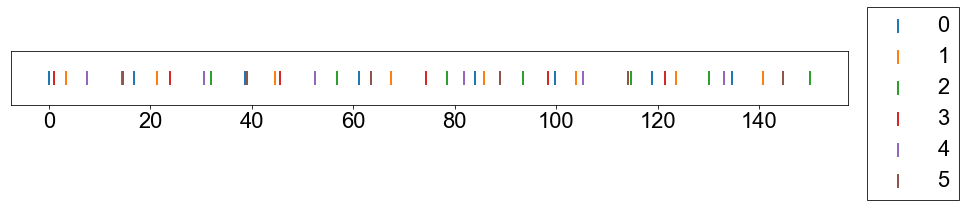

In [39]:
multigraph1.plotEvents(end=numEvents+1)

In [40]:
c_predictions = np.empty((clgraph.deltas.shape[0],clgraph.num_stimuli))
m_dc_predictions = np.empty((clgraph.deltas.shape[0],clgraph.num_stimuli))
m_predictions = np.empty((clgraph.deltas.shape[0],clgraph.num_stimuli))


for i, delta in enumerate(clgraph.deltas):
    c_predictions[i] = clgraph.makePrediction(delta,normalized=False,type='C')
    m_dc_predictions[i] = clgraph.makePrediction(delta,normalized=False,type='M')
    
    ftildedelta = (clgraph.Ck[:]*clgraph.dkdsk.dot(np.exp(-clgraph.s*delta)))[clgraph.k:-clgraph.k]
    ftildedelta[ftildedelta<0] = 1e-20
    temp = np.log(clgraph.Mnorm[:,np.argmax(multigraph1.eventsOneHot[:,numEvents-1]),:])*ftildedelta[:,np.newaxis]
    m_predictions[i] = clgraph.kappa*np.exp(np.trapz(y=temp,x=clgraph.taustars[clgraph.k:-clgraph.k],axis=0))

    

In [41]:
from creditlearning import bounded_log, bounded_exp

m_dc_predictions = np.empty((clgraph.deltas.shape[0],clgraph.num_stimuli))

for i, delta in enumerate(clgraph.deltas):
    prefactor = clgraph.counts/clgraph.appearances if clgraph.pbase is None else clgraph.pbase
    ftilde_delta = np.exp(-clgraph.s[:,np.newaxis]*delta)*clgraph.F
    ftilde_delta = clgraph.dkdsk.dot(ftilde_delta)
    ftilde_delta = (clgraph.Ck[:,np.newaxis]*ftilde_delta)[clgraph.k:-clgraph.k,:]
    
    ftilde_delta[ftilde_delta<0] = 1e-20
    m_dc_predictions[i] = bounded_exp(np.einsum('tij,ti->j',bounded_log(1e-20+15*clgraph.Mnorm),ftilde_delta*clgraph.taustarmeasure[:,np.newaxis]))


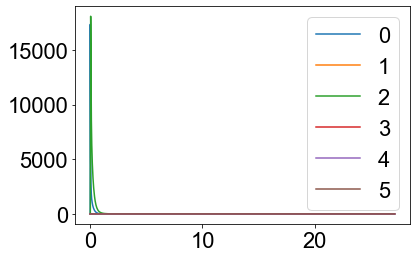

In [42]:
for i in range(clgraph.num_stimuli):
    plt.plot(clgraph.deltas,c_predictions[:,i],label=i)
plt.legend()

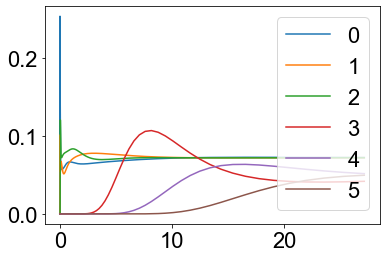

In [43]:
for i in range(clgraph.num_stimuli):
    plt.plot(clgraph.deltas,m_predictions[:,i],label=i)
plt.legend()

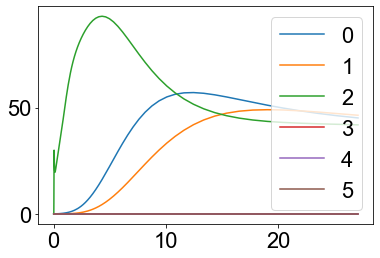

In [44]:
for i in range(clgraph.num_stimuli):
    plt.plot(clgraph.deltas,m_dc_predictions[:,i],label=i)
plt.legend()

In [45]:
accuracies, accuraciesM, accuraciesBaseline, perplexities, perplexitiesM, perplexitiesBaseline = clgraph.predictOnSequence(f=trainSetOneHot,
                                            event_times=multigraph1.timeInds,
                                            withMprediction=True, doublecount=1,verbose=0,returnPredictions=False)

Using M with double counting
Accuracy C :  0.7131670533642691
Accuracy M :  0.6003480278422274
Baseline probability :  0.1931554524361949


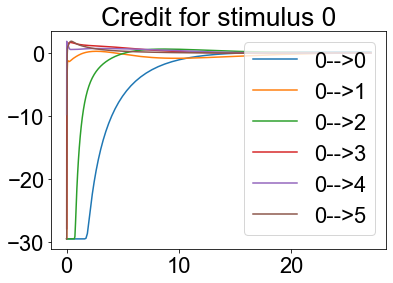

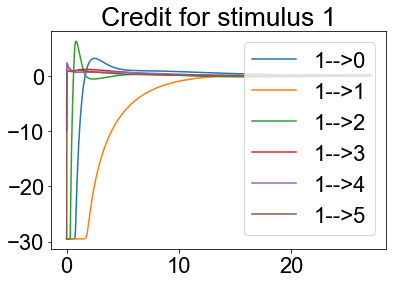

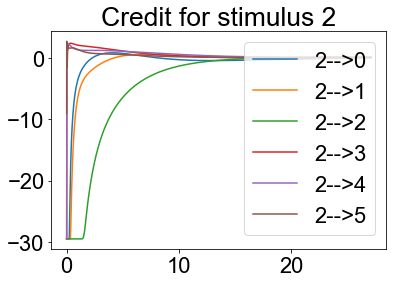

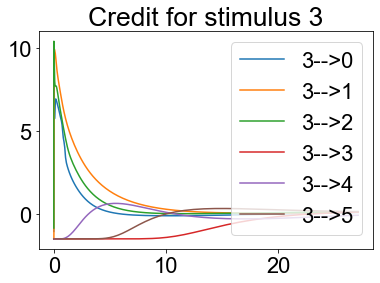

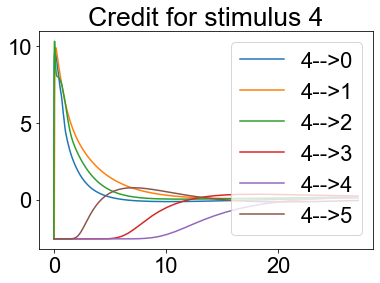

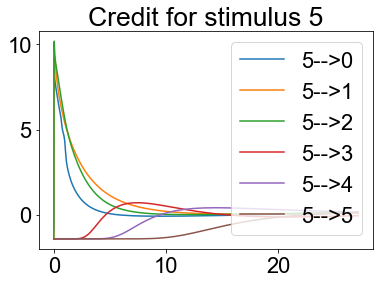

In [46]:
clgraph.plotCredit(log=True)

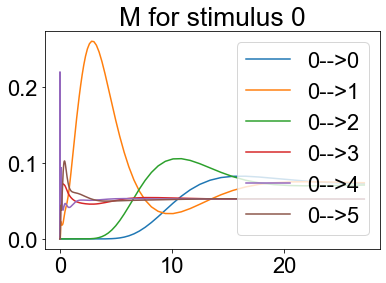

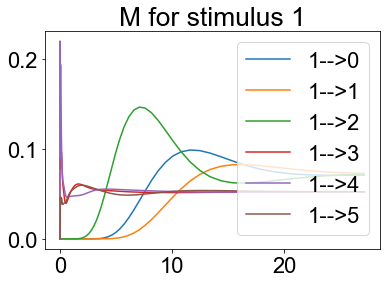

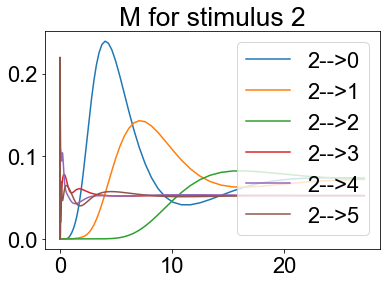

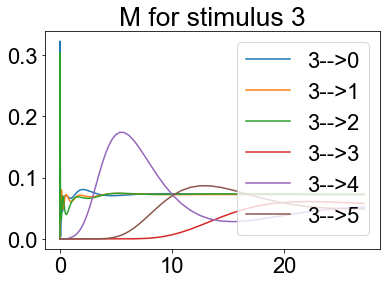

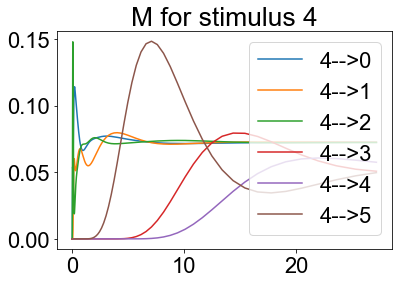

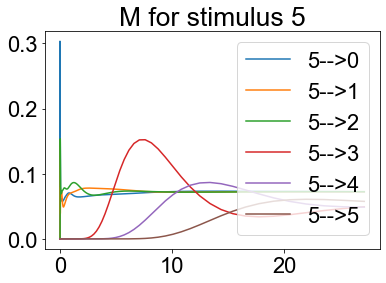

In [47]:
clgraph.plotM(conv=False)


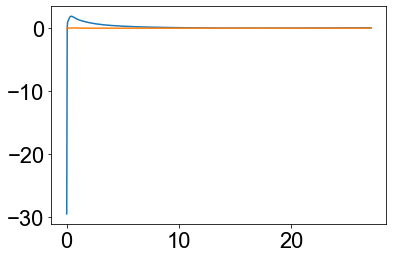

In [48]:
i = 0
j = 5

plt.plot(clgraph.deltas,np.log(clgraph.expC[:,i,j]))
plt.plot(clgraph.deltas,clgraph.Mconv[:,i,j])

In [ ]:
# allAccuracies = np.load('./final data/allAccuracies.npy')
# allAccuraciesM = np.load('./final data/allAccuraciesM.npy')
# allAccuraciesBaseline = np.load('./final data/allAccuraciesBaseline.npy')
# allPerplexities = np.load('./final data/allPerplexities.npy')
# allPerplexitiesM = np.load('./final data/allPerplexitiesM.npy')
# allPerplexitiesBaseline = np.load('./final data/allPerplexitiesBaseline.npy')

# print(allAccuracies)

maxNumProcesses = allAccuracies.shape[1]
plt.figure(figsize=(1.4*6.4,1.4*4.8))
matplotlib.font_manager._rebuild()
plt.rcParams.update({'font.size': 22, 'font.family': 'FreeSans',
                    'mathtext.fontset': 'custom',
                    'mathtext.rm': 'FreeSans',
                    'mathtext.cal': 'FreeSans:oblique',
                    'mathtext.it': 'FreeSans:oblique',
                    'mathtext.bf': 'FreeSans:bold'})

plt.title("Multiple superimposed processes")
plt.ylim(0,1)
plt.xticks(np.arange(1,maxNumProcesses+1))
plt.xlabel("Number of processes")
plt.ylabel("Accuracy on Test Set")


for i in range(allAccuracies.shape[0]):
    plt.plot(np.arange(1,maxNumProcesses+1),allAccuracies[i],ls='dotted',color='red',alpha=0.3)
    plt.plot(np.arange(1,maxNumProcesses+1),allAccuraciesM[i],ls='dotted',color='black',alpha=0.3)
    plt.plot(np.arange(1,maxNumProcesses+1),allAccuraciesBaseline[i],ls='dotted',color='green',alpha=0.3)


plt.errorbar(np.arange(1,maxNumProcesses+1),np.mean(allAccuracies,axis=0),np.sqrt(np.var(allAccuracies,axis=0)),label="C",color='red')
plt.errorbar(np.arange(1,maxNumProcesses+1),np.mean(allAccuraciesM,axis=0),np.sqrt(np.var(allAccuraciesM,axis=0)),label="M",color='black')
plt.errorbar(np.arange(1,maxNumProcesses+1),np.mean(allAccuraciesBaseline,axis=0),np.sqrt(np.var(allAccuraciesBaseline,axis=0)),label="Baseline",color='green')


plt.legend()
plt.show()
plt.savefig('./accuracyVnumProcesses.png')